#### 导入数据

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

In [3]:
df_train = pd.read_csv('./data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('./data/test.csv', encoding="ISO-8859-1")

In [4]:
df_desc = pd.read_csv('./data/product_descriptions.csv')

In [6]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [7]:
df_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [10]:
df_all = pd.concat((df_train, df_test), axis=0,sort='True', ignore_index=True)

In [12]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


In [13]:
df_all.shape

(240760, 5)

In [15]:
df_all = pd.merge(df_all,df_desc,how = 'left',on='product_uid')

In [16]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...


#### 文本预处理

In [21]:
#词干提取
stemmer = SnowballStemmer('english')
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [22]:
#统计str1在str2中出现的次数
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [23]:
#对search_term进行词干提取
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))

In [24]:
#对product_title、product_description同样进行词干提取
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

#### 特征工程（造特征）

In [26]:
#搜索词的长度
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

#搜索词中有几个在产品title出现过
df_all['commons_in_title'] = df_all.apply(lambda x:str_common_word(x['search_term'],x['product_title']), axis=1)

#搜索词中有几个在产品介绍出现过
df_all['commons_in_desc'] = df_all.apply(lambda x:str_common_word(x['search_term'],x['product_description']), axis=1)

#drop掉文本特征
df_all = df_all.drop(['search_term','product_title','product_description'],axis=1)

#### 切分数据集

In [27]:
df_train = df_all.loc[df_train.index]
df_test = df_all.loc[df_test.index]

In [28]:
#记录id号
test_ids = df_test['id']

In [29]:
y_train = df_train['relevance'].values

In [30]:
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

#### 建立模型

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [32]:
#5折的网格搜索交叉验证
params = [1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

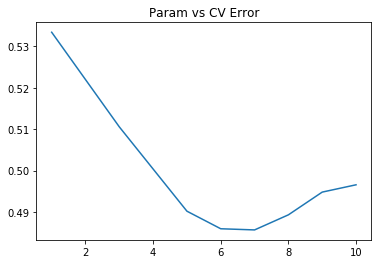

In [33]:
#绘图看一下mse
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error");

In [34]:
#上图可以看到最大树深为6时效果最好
rf = RandomForestRegressor(n_estimators=30, max_depth=6)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
y_pred = rf.predict(X_test)

In [36]:
#导出结果
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('submission.csv',index=False)